# Poisson equation in 2D: joint estimation of the solution and the diffusion 

This is a **jinns** reimplementation of the inverse problem studied in [this article](https://arxiv.org/pdf/2306.08827.pdf) for example, the original code is available [here](https://github.com/i207M/PINNacle/blob/main/src/pde/inverse.py#L58).

Consider the following PDE on $\Omega=[0,1]^2$:
$$
\begin{cases}
-\nabla(a(x,y)\nabla u(x,y)) = f(x, y),\\
f(x,y)=\frac{2\pi^2\sin\pi x\sin\pi y}{1+x^2+y^2+(x-1)^2+(y-1)^2}+
\frac{2\pi((2x-1)\cos\pi x\sin\pi y+(2y-1)\sin\pi x\cos \pi y)}{(1+x^2+y^2+(x-1)^2+(y-1)^2)^2}, \text{ (source term)}.
\end{cases}
$$
On ther boundary $\partial\Omega$ we set
$$
a(x,y) = \frac{1}{1+x^2+y^2+(x-1)^2+(y-1)^2}.
$$

We get that the true solution on $\Omega$ that we will estimate with a PINN is 
$$
u(x,y)=\sin\pi x\sin\pi y.
$$
The ground truth on $\Omega$ of the diffusion coefficient is
$$
a(x,y) = \frac{1}{1+x^2+y^2+(x-1)^2+(y-1)^2}.
$$



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns


Import other dependencies

In [3]:
import jax
import numpy as np
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt
import time

key = random.PRNGKey(2)
key, subkey = random.split(key)

2024-10-07 15:54:23.305979: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Observations

We simulate some observations

In [4]:
def u_true(x):
    return jnp.sin(jnp.pi * x[0]) * jnp.sin(jnp.pi * x[1])
v_u_true = vmap(u_true)

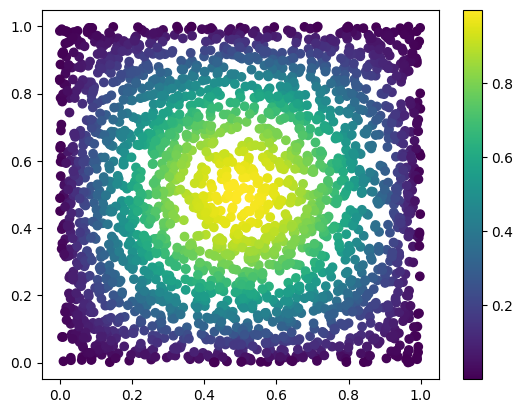

In [5]:
key, subkey = jax.random.split(key)
n_obs = 2500
x = jax.random.uniform(subkey, shape=(n_obs, 2), minval=0.0, maxval=1.0)
obs = v_u_true(x)

obs_batch = jnp.concatenate([
    x[..., 0:1], x[..., 1:2], obs[..., None]
    ], axis=-1)

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


__Optionally blur the observed values__

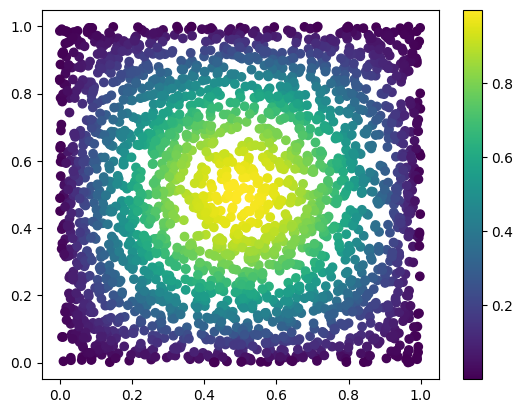

In [6]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] +
    0 #random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


Create the neural network architecture for the PINN. The network will have two outputs:

- $u(x,y)$, the classical PINN output
- $a(x, y)$. This secondary PINN output should then be treated as the diffusion coefficient, i.e., an equation parameter. However, in **jinns** equation parameters are fed through the dictionary `Params.eq_params`. Thus, in order to feed the second PINN output to the dictionnary, one needs to specify a transform using the `eq_params_heterogeneity` argument. We discuss this in more details in below in the loss construction section.

In [7]:
eqx_list = (
    (eqx.nn.Linear, 2, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 2)
)

key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2, slice_solution=jnp.s_[:1])
init_nn_params = u.init_params()

In [8]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "a":0. # The second output of the PINN will correspond to the diffusion coefficient, so the value here is irrelevant
    }
)

Create a DataGenerator object

In [9]:
n = 500
nb = 320
omega_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    dim=dim,
    min_pts=(xmin, xmin),
    max_pts=(xmax, xmax),
    method=method
)

Create the DataGenerator for observations

In [10]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    omega_batch_size,
    observed_pinn_in=obs_batch[:, 0:2],
    observed_values=obs_batch[:, 2:3]
)

## Loss construction

Importantly, the loss contains **heterogeneous parameters** (*i.e.* which possibly depends on `(x,y)` and `params`). This can be managed by defining a dictionary `eq_params_heterogeneity` where keys match the ones in `Params.eq_params`, and values can be by any kind of jit-able function that returns equation parameters. 

Here, the diffusion parameter (`Params.eq_params["a"]`) is defined to be the second output of the whole network. Thus, we simply design a custom transform function set to key `"a"` of the `eq_params_heterogeneity` dictionary. Note that whatever the transform, the signature of such a function must be `x, u, params` in the non-stationary case we are dealing with here.

The rest of the implementation is as-usal in **jinns** : we define the `eqx.Module` subclassing `PDENonStatio` with its `equation` method. The parameters heterogeneity will be handled internally by the package.

In [11]:
def a_to_pinn_output(x, u, params):
    """
    A jittable function that attributes the second output of u to the diffusion coefficient a
    """
    return lambda x, params: u(x, params)[1]

eq_params_heterogeneity = {"a": a_to_pinn_output} # STEP 1.

In [12]:
from jinns.loss._DynamicLossAbstract import PDEStatio

class PoissonLoss2D(PDEStatio):
    def __init__(self, eq_params_heterogeneity):
        super().__init__(eq_params_heterogeneity=eq_params_heterogeneity)

    def equation(self, x, u, params):
        # Because of the decoration with evaluate_heterogeneous_parameters the params we receive are 
        # already modified with the user defined eq_params_heterogeneity
        u_pinn = lambda x, params: jnp.squeeze(u(x, params)[u.slice_solution])
        def source_term(xy, params):
            x, y = xy[0], xy[1]
            return (
                (2 * jnp.pi**2 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)) / (1 + x ** 2 + y ** 2 + (x-1) ** 2 + (y-1)**2)
                + 2 * jnp.pi * (
                    (2 * x + 1) * jnp.cos(jnp.pi * x) * jnp.sin(jnp.pi * y)
                    + (2 * y + 1) * jnp.sin(jnp.pi * x) * jnp.cos(jnp.pi * y)
                )  / (1 + x ** 2 + y ** 2 + (x-1) ** 2 + (y-1)**2) ** 2
            )
        a_times_jac_u = lambda x, params: params.eq_params["a"](x, params) * jax.jacrev(u_pinn, 0)(x, params)
        return jinns.loss._operators._div_rev(None, x, a_times_jac_u, params) + source_term(x, params)

In [13]:
poisson_loss = PoissonLoss2D(
    eq_params_heterogeneity=eq_params_heterogeneity
)

Create the boundary function and the global loss

In [14]:
def a_boundary(dx):
    dx, dy = dx[0], dx[1]
    return 1 / (1 + dx ** 2 + dy ** 2 + (dx - 1) ** 2 + (dy - 1) ** 2)

In [15]:
loss_weights = jinns.loss.LossWeightsPDEStatio(
    dyn_loss=1, 
    boundary_loss=10,
    observations=10
)

loss = jinns.loss.LossPDEStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=poisson_loss,
    omega_boundary_fun=lambda dx: a_boundary(dx),
    omega_boundary_condition="dirichlet",
    omega_boundary_dim=jnp.s_[1],
)


In [16]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = jinns.data.append_obs_batch(train_data.get_batch()[1], obs_data.get_batch()[1])
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 888.18
Individual losses: {'boundary_loss': '9.33', 'dyn_loss': '876.95', 'initial_condition': '0.00', 'norm_loss': '0.00', 'observations': '1.91'}


## Joint estimation of `a(x,y)` and `nn_params`

In [17]:
params = init_params


In [18]:
import optax
n_iter = 100000
tx = optax.adamw(learning_rate=5e-4)

Then start optimization

In [19]:
key, subkey = random.split(key, 2)
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, tracked_params , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=10000,
    obs_data=obs_data
)
end = time.time()

[train] Iteration 0: loss value = 808.108154296875
[train] Iteration 10000: loss value = 0.12133229523897171
[train] Iteration 20000: loss value = 0.07551290094852448
[train] Iteration 30000: loss value = 0.13205267488956451
[train] Iteration 40000: loss value = 0.07662162184715271
[train] Iteration 50000: loss value = 0.14059655368328094
[train] Iteration 60000: loss value = 0.04984838515520096
[train] Iteration 70000: loss value = 0.14925654232501984
[train] Iteration 80000: loss value = 0.03351316601037979
[train] Iteration 90000: loss value = 0.050685226917266846
Stopping main optimization loop, cause: max iteration is reached
Final iteration 100000: train loss value = 0.11235867440700531


In [20]:
time_training = end - start
print("Time training", time_training)

Time training 191.97982740402222


## Results

Plot the loss values

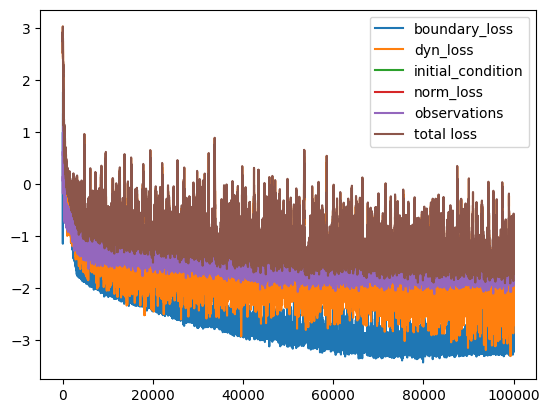

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solutions learned by the PINN

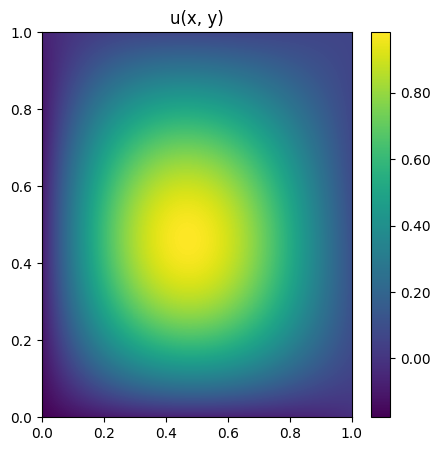

In [22]:
u_est = lambda x: u(x, params)[0]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(u_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="u(x, y)")

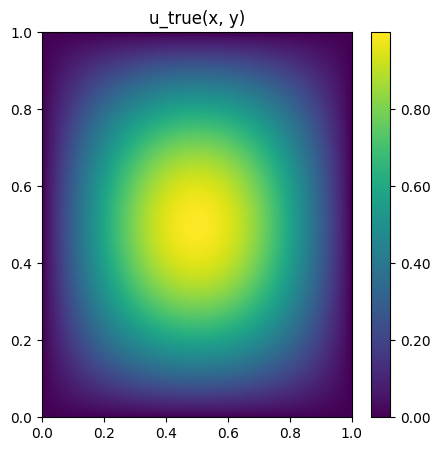

In [23]:
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(u_true, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="u_true(x, y)")

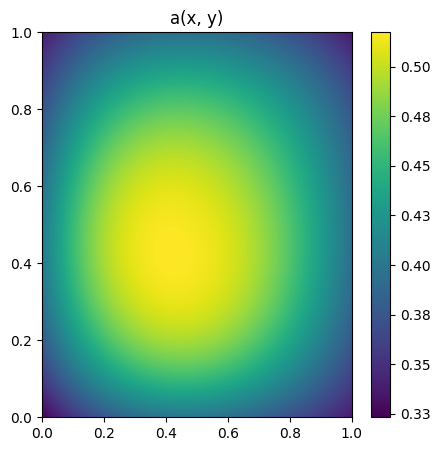

In [24]:
a_est = lambda x: u(x, params)[1]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(a_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="a(x, y)")

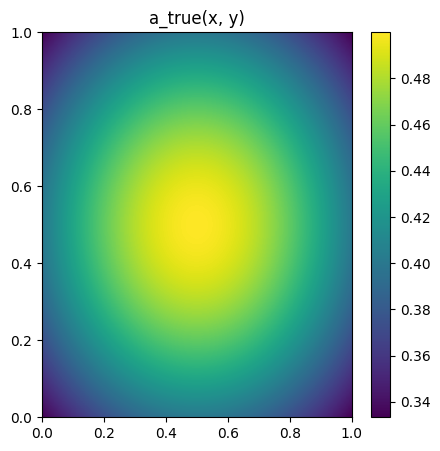

In [25]:
a_true = a_boundary
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(a_true, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="a_true(x, y)")

## Conclusion

The results have been computed in around 3minutes. Specific finetuning and longer training would bring more precise results.